#**Business Objective:**

The goal of this project is to develop a robust forecasting model for hourly energy consumption within the PJM Interconnection region of the United States. Using historical megawatt (MW) demand data, the project aims to uncover patterns related to hourly usage, seasonality, and holiday effects, and to ultimately generate accurate 30-day energy demand forecasts. These insights can support operational planning, peak load management, and data-driven energy distribution across PJM's extensive multi-state grid.

#Dataset Details:

* **Datetime:** This column has the date and time recorded for the energy demand.
* **PJMW_MW:** This column has the enery units recorded at the given particular date and time.

In [ ]:
#  Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")

In [ ]:
#  Load the dataset
df = pd.read_csv("/content/PJMW_Energy_Demand.csv")
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [ ]:
df.shape

(143206, 2)

In [ ]:
df.columns

Index(['Datetime', 'PJMW_MW'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  143206 non-null  object 
 1   PJMW_MW   143206 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
# Checking for Null Values
print(df.isnull().sum().sum())

0


In [ ]:
# Let's Check for duplicates
print(df.duplicated().sum())

0


In [ ]:
# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [ ]:
# Set 'Datetime' as the index for time-series analysis
df.set_index('Datetime', inplace=True)

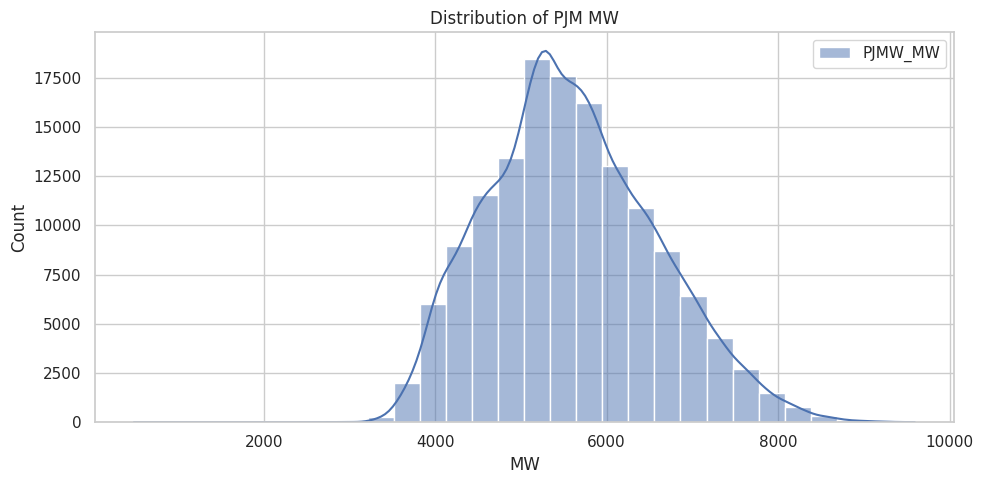

In [ ]:
# Distribution of of PJMW_MW column
plt.figure(figsize=(10, 5))
sns.histplot(df, kde=True, bins=30, color='tab:green')
plt.title('Distribution of PJM MW')
plt.xlabel('MW')
plt.tight_layout()
plt.show()

In [ ]:
#  Feature Engineering: Add useful time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek  # Monday = 0, Sunday = 6
df['weekday_name'] = df.index.day_name()
df['month'] = df.index.month
df['year'] = df.index.year
df['day'] = df.index.day
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['Season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall',   10: 'Fall',  11: 'Fall'
})

#  Add US federal holidays
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.index.min(), end=df.index.max())
df['is_holiday'] = df.index.isin(holidays).astype(int)

In [ ]:
df.head()

,PJMW_MW,hour,dayofweek,weekday_name,month,year,day,is_weekend,Season,is_holiday
Datetime,,,,,,,,,,
2002-12-31 01:00:00,5077.0,1,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 02:00:00,4939.0,2,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 03:00:00,4885.0,3,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 04:00:00,4857.0,4,1,Tuesday,12,2002,31,0,Winter,0
2002-12-31 05:00:00,4930.0,5,1,Tuesday,12,2002,31,0,Winter,0


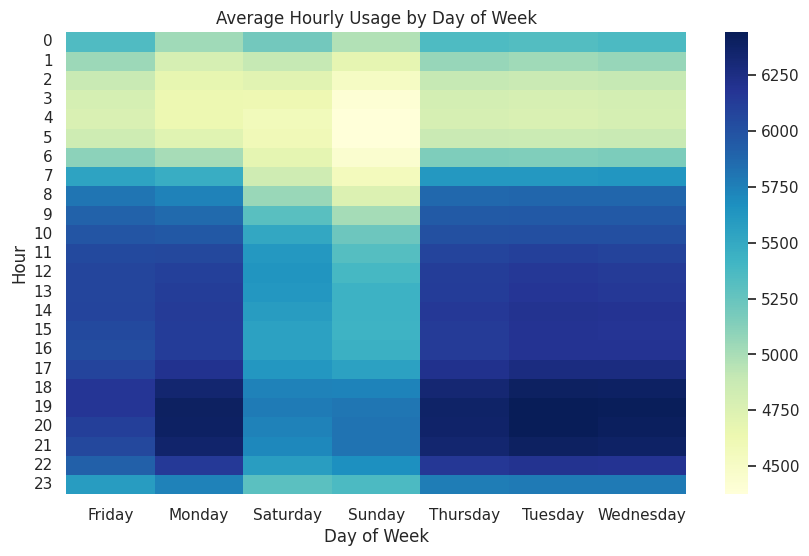

In [ ]:
# Heatmap: Average Hourly Usage by Day of Week
# Shows patterns in usage across different hours and weekdays
pivot1 = df.pivot_table(values='PJMW_MW', index='hour', columns='weekday_name', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot1, cmap="YlGnBu")
plt.title("Average Hourly Usage by Day of Week")
plt.ylabel("Hour")
plt.xlabel("Day of Week")
plt.show()

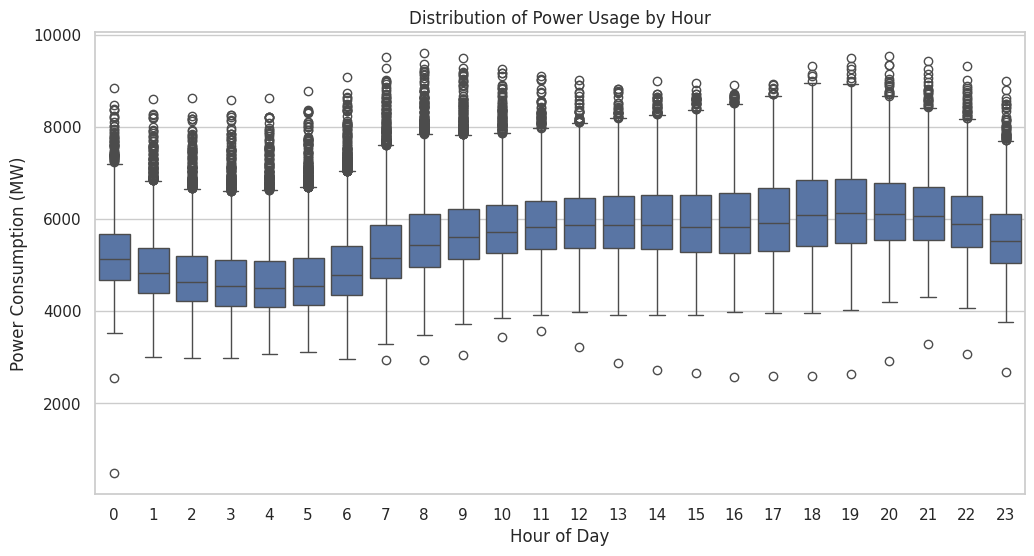

In [ ]:
# Boxplot: Hourly Distribution
# Helps understand variation and outliers in energy use per hour
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='PJMW_MW', data=df)
plt.title("Distribution of Power Usage by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Power Consumption (MW)")
plt.show()

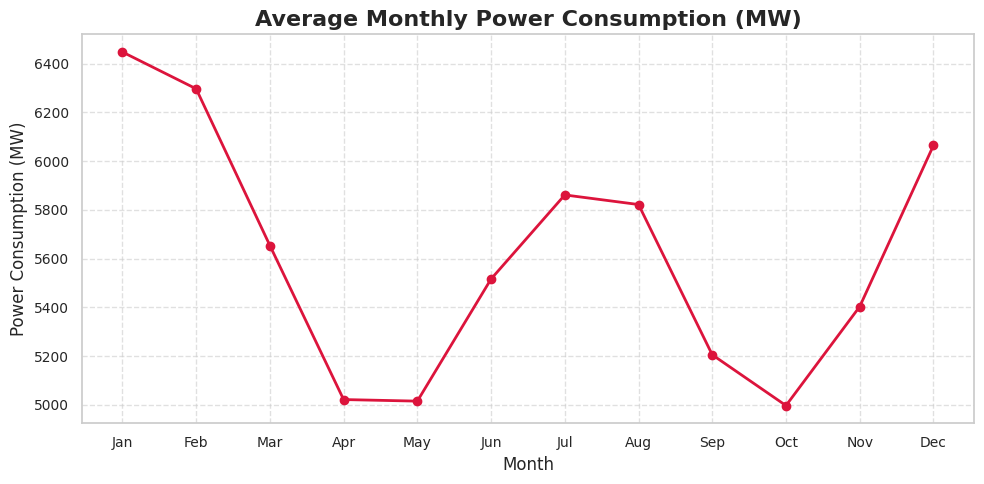

In [ ]:
monthly_avg = df.groupby('month')['PJMW_MW'].mean()

# Month names for x-axis
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(10, 5))
plt.plot(month_names, monthly_avg.values, marker='o', color='crimson', linewidth=2)

# Beautify
plt.title("Average Monthly Power Consumption (MW)", fontsize=16, fontweight='bold')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Power Consumption (MW)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show
plt.show()

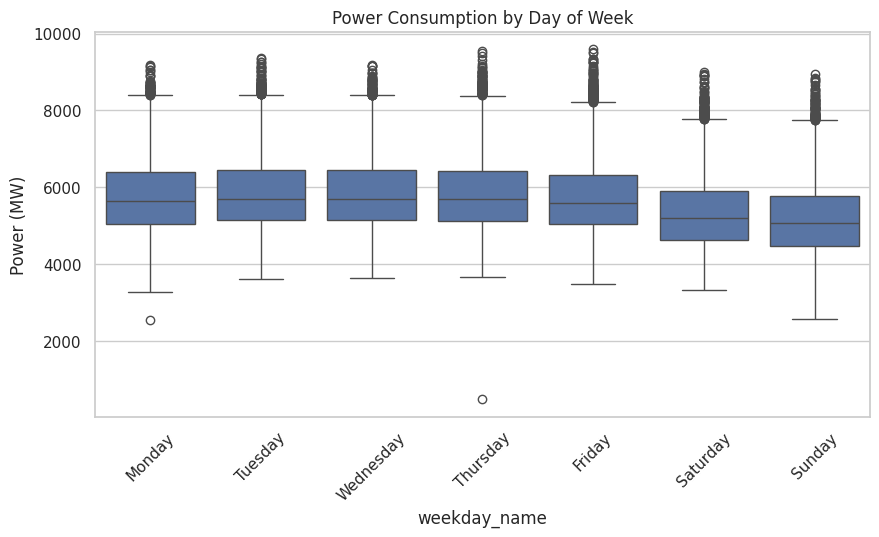

In [ ]:
# Boxplot: Day of Week
# Examines energy usage spread for each day of the week
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday_name', y='PJMW_MW', data=df,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Power Consumption by Day of Week")
plt.xticks(rotation=45)
plt.ylabel("Power (MW)")
plt.show()

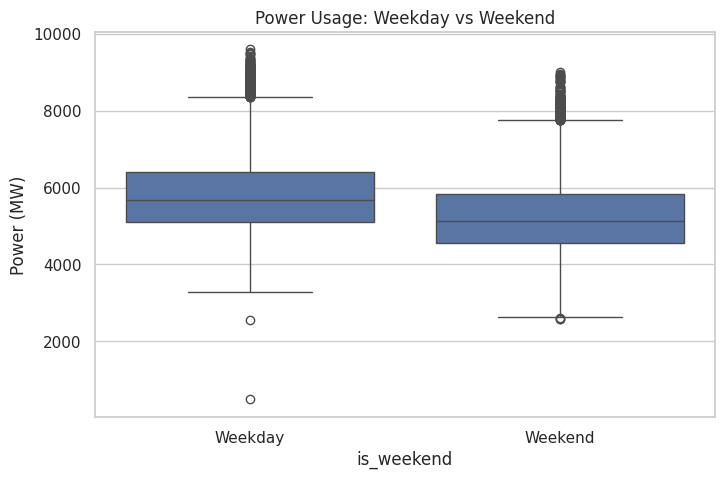

In [ ]:
# Boxplot: Weekend vs Weekday
# Checks if weekends show different energy use compared to weekdays
plt.figure(figsize=(8, 5))
sns.boxplot(x='is_weekend', y='PJMW_MW', data=df)
plt.title("Power Usage: Weekday vs Weekend")
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.ylabel("Power (MW)")
plt.show()

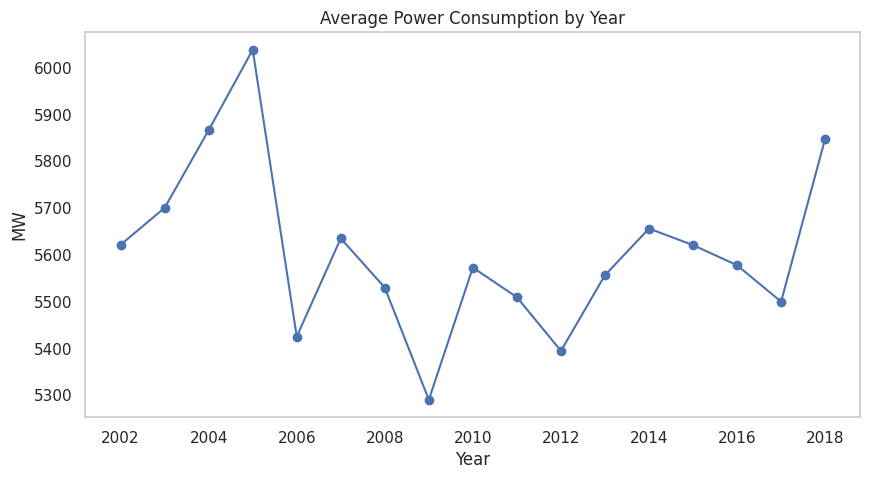

In [ ]:
# Lineplot: Average Usage by Year
# Shows long-term trend over the years
yearly_avg = df.groupby('year')['PJMW_MW'].mean()
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg.index, yearly_avg.values, marker='o')
plt.title("Average Power Consumption by Year")
plt.xlabel("Year")
plt.ylabel("MW")
plt.grid()
plt.show()

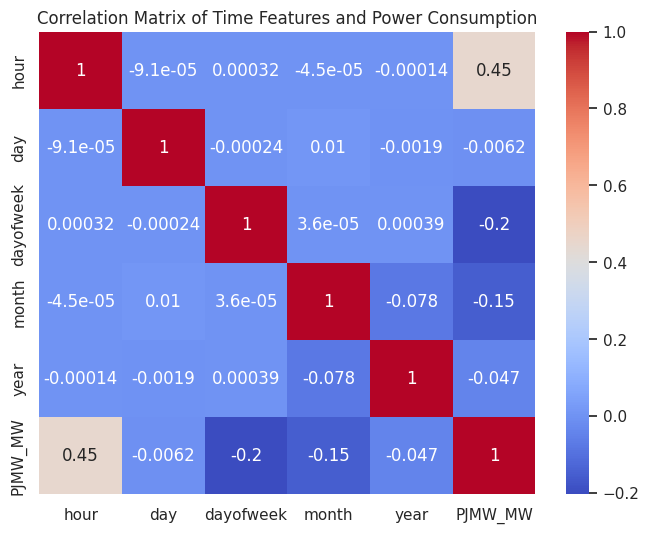

In [ ]:
# Correlation Heatmap
# Displays relationships between time-based features and power usage
plt.figure(figsize=(8, 6))
correlation = df[['hour', 'day', 'dayofweek', 'month', 'year', 'PJMW_MW']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Time Features and Power Consumption")
plt.show()

#ETS Decomposition using STL

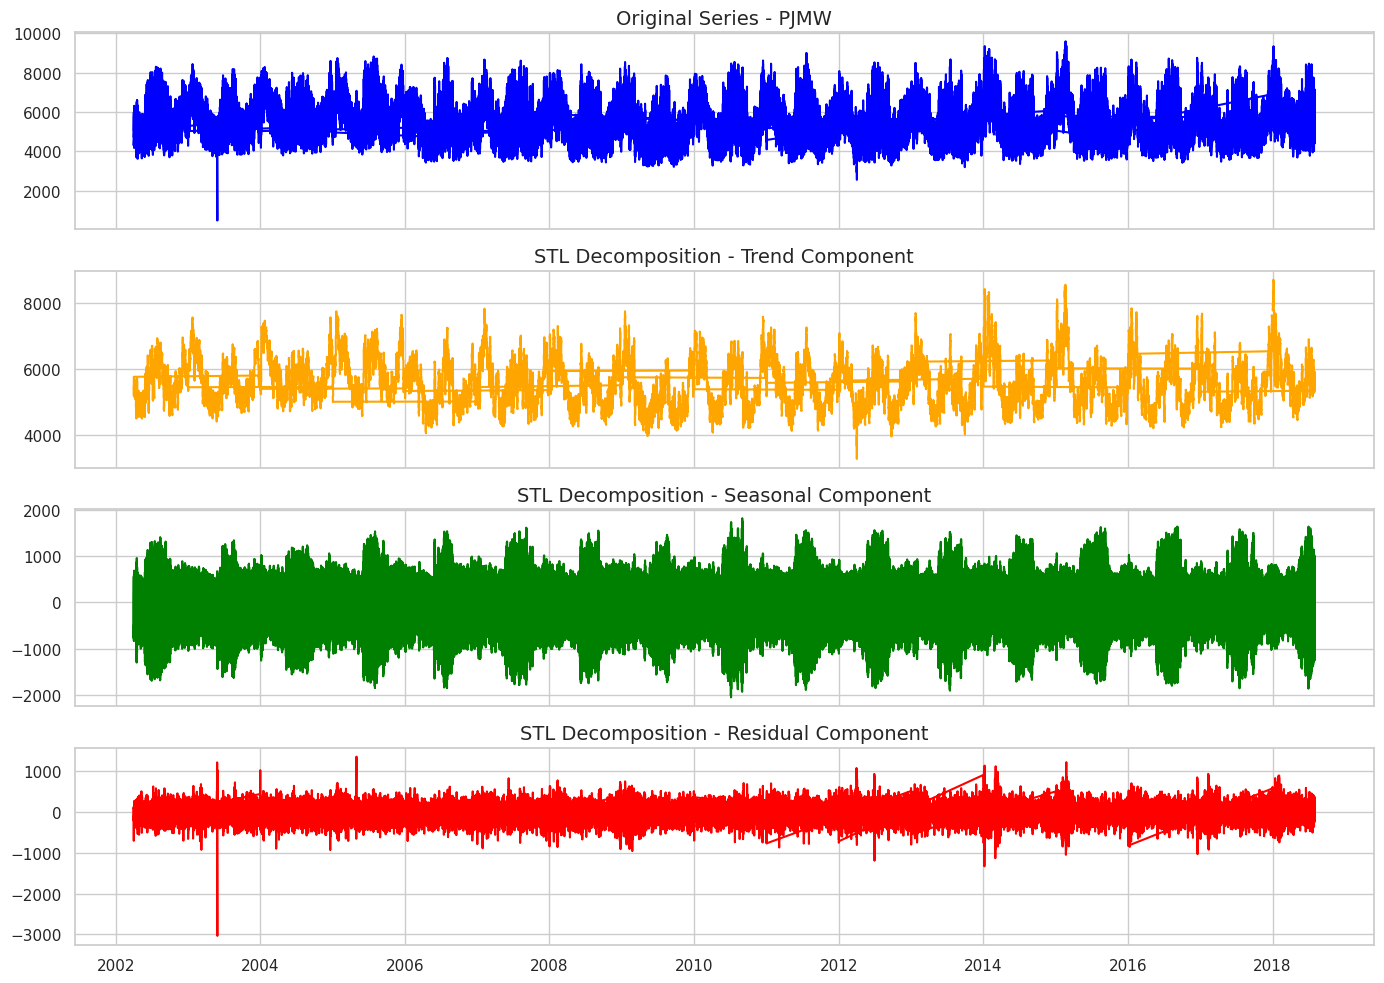

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Apply STL decomposition
stl = STL(df['PJMW_MW'], period=24)  # adjust 'period' as needed (e.g., 24 for hourly daily seasonality)
res = stl.fit()

# Create figure with 4 subplots (including original PJMW)
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original Series (PJMW)
axs[0].plot(df.index, df['PJMW_MW'], color='blue')
axs[0].set_title("Original Series - PJMW", fontsize=14)
axs[0].grid(True)

# Trend Component
axs[1].plot(df.index, res.trend, color='orange')
axs[1].set_title("STL Decomposition - Trend Component", fontsize=14)
axs[1].grid(True)

# Seasonal Component
axs[2].plot(df.index, res.seasonal, color='green')
axs[2].set_title("STL Decomposition - Seasonal Component", fontsize=14)
axs[2].grid(True)

# Residual Component
axs[3].plot(df.index, res.resid, color='red')
axs[3].set_title("STL Decomposition - Residual Component", fontsize=14)
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Resampling the data on daily baisis and taking each day's mean value
df = round(df["PJMW_MW"].resample('D').mean(),2)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df

,PJMW_MW
Datetime,
2002-04-01,5271.17
2002-04-02,5310.42
2002-04-03,5325.92
2002-04-04,5670.79
2002-04-05,5686.12
...,...
2018-07-30,5492.71
2018-07-31,5660.75
2018-08-01,5959.71


In [ ]:
# Test for stationarity using Hypothesis Testing
from statsmodels.tsa.stattools import adfuller

# Apply ADF test
result = adfuller(df)

# Print the results
print("Augmented Dickey-Fuller Test:")
print(f"ADF Statistic      : {result[0]}")
print(f"p-value            : {result[1]}")
print(f"Critical Values    :")
for key, value in result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if result[1] <= 0.05:
    print("✅ The series is stationary (reject null hypothesis).")
else:
    print("⚠️ The series is non-stationary (fail to reject null hypothesis).")

Augmented Dickey-Fuller Test:
ADF Statistic      : -7.264798078159698
p-value            : 1.645687388358858e-10
Critical Values    :
   1%: -3.43145229664056
   5%: -2.8620271128107553
   10%: -2.56702928783387
✅ The series is stationary (reject null hypothesis).


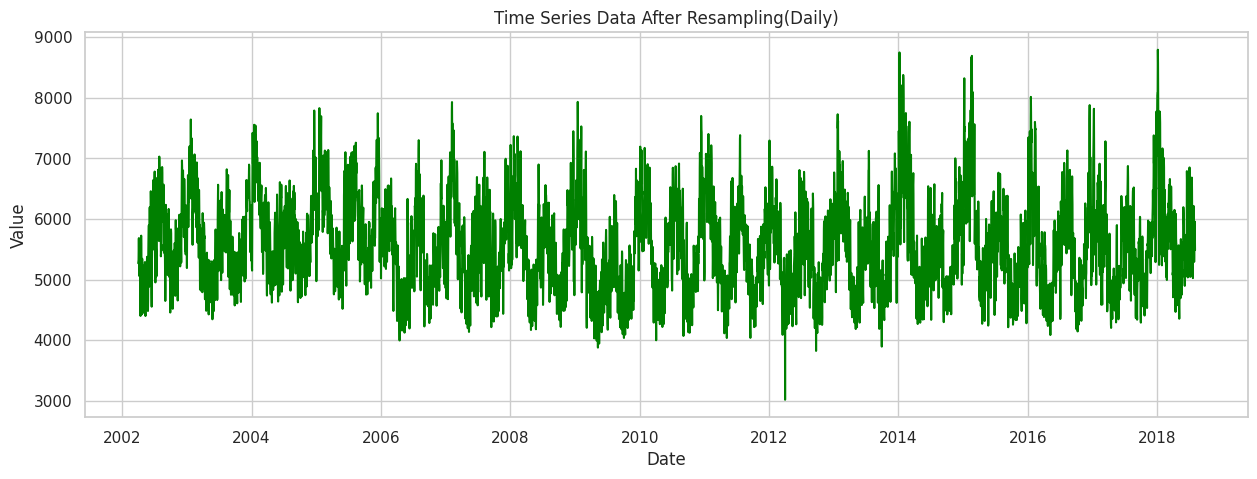

In [ ]:
# Plot of time series data after resampling
plt.figure(figsize=(15, 5))
plt.plot(df, color="green")
plt.title("Time Series Data After Resampling(Daily)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

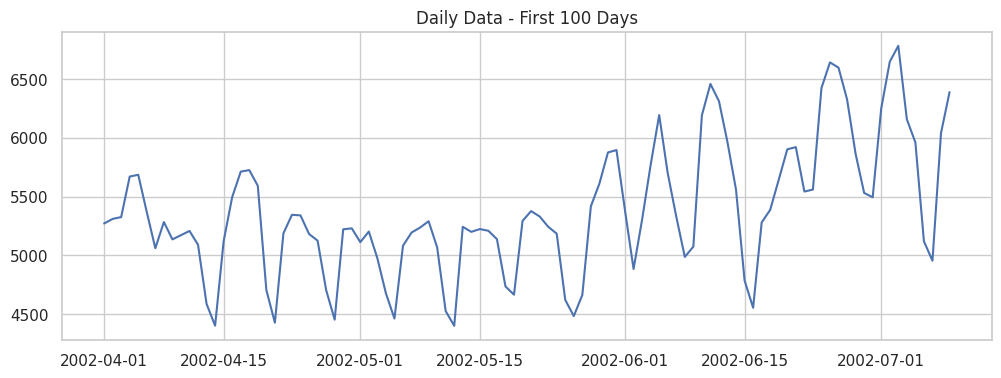

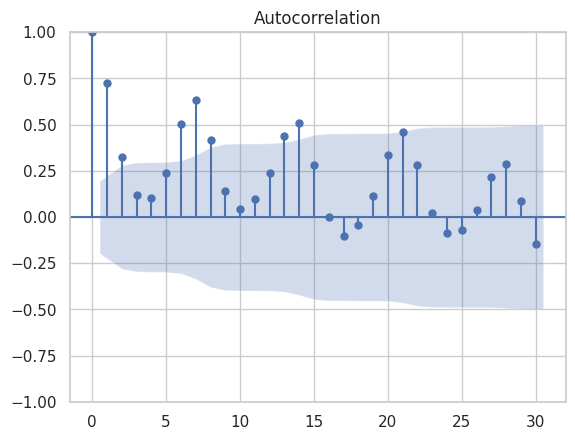

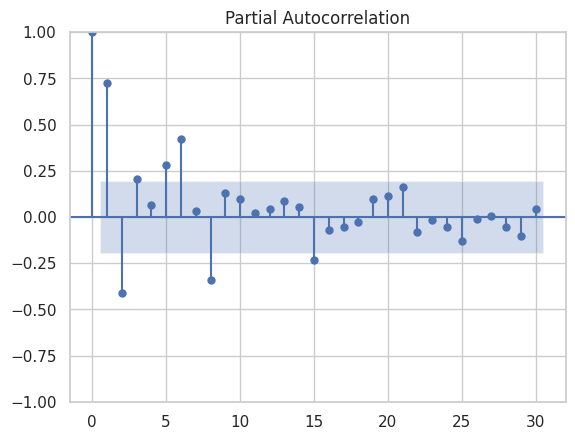

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

first_100_days = df.iloc[:100]

plt.figure(figsize=(12, 4))
plt.plot(first_100_days)
plt.title("Daily Data - First 100 Days")
plt.show()

plot_acf(first_100_days.dropna(), lags=30)
plot_pacf(first_100_days.dropna(), lags=30)
plt.show()


#ETS Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Split into Train/Test (last 30d)
train = df.iloc[:-30]
test = df.iloc[-30:]

In [ ]:
# Step 3: Fit ETS Model
model = ExponentialSmoothing(train, trend='add', seasonal=None)
ets_fitted = model.fit()

# Step 4: Forecast 14 steps
forecast = ets_fitted.forecast(steps=30)
# forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# Evaluate RMSE
y_true = test.values
y_pred = forecast.values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print Results
print(f"ETS MSE (Daily): {rmse:.2f}")

ETS MSE (Daily): 571.26


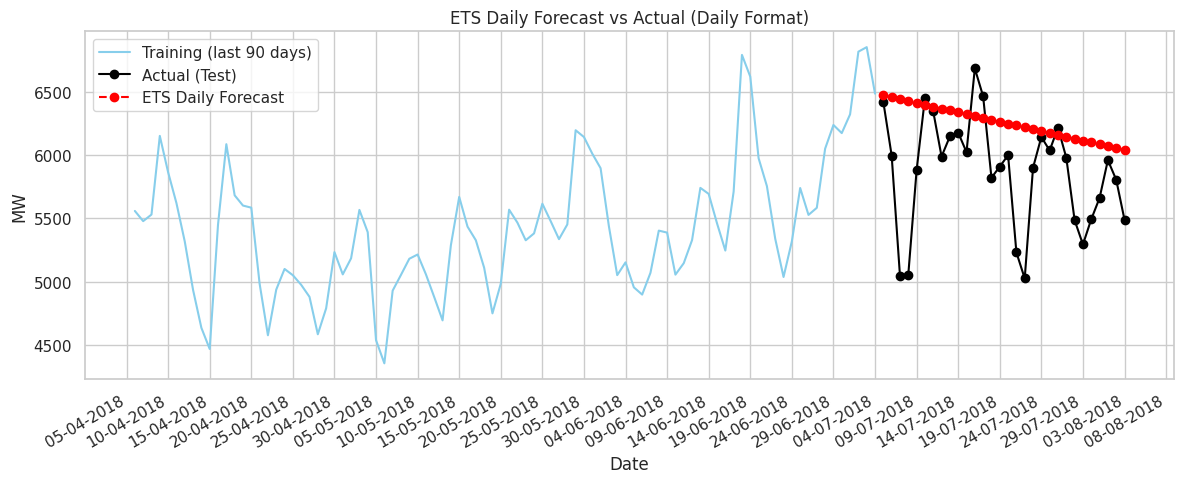

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # ✅ Required for formatting date axis

plt.figure(figsize=(12, 5))

# Plot data
plt.plot(train[-90:], label="Training (last 90 days)", color="skyblue")
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(forecast, label="ETS Daily Forecast", color="red", linestyle='--', marker='o')

# Plot formatting
plt.title("ETS Daily Forecast vs Actual (Daily Format)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.grid(True)
plt.legend()

# ✅ Format x-axis to show only the date (not time)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Daily format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))       # Show every 2 days
plt.gcf().autofmt_xdate()  # Rotate for readability

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Try different ARIMA (p,d,q) combinations
orders = [(2, 0, 2),(2, 0, 1),(1, 0, 2), (2, 1, 2), (2, 1, 1), (1, 1, 2), (3, 1, 2),
          (1, 1, 3), (3, 1, 3), (3, 1, 1)]

for order in orders:
    try:
        model = ARIMA(train, order=order)  # ✅ Use univariate series
        model_fit = model.fit()

        # Forecast future values equal to test size (for example, 14)
        forecast = model_fit.forecast(steps=30)

        # Compare with last 30 actual values
        actual = test.values
        rmse = np.sqrt(mean_squared_error(actual, forecast))

        print(f"✅ ARIMA{order} - MSE: {rmse:.2f}")
    except Exception as e:
        print(f"❌ ARIMA{order} failed: {e}")


✅ ARIMA(2, 0, 2) - MSE: 436.13
✅ ARIMA(2, 0, 1) - MSE: 483.74
✅ ARIMA(1, 0, 2) - MSE: 454.14
✅ ARIMA(2, 1, 2) - MSE: 519.17
✅ ARIMA(2, 1, 1) - MSE: 557.78
✅ ARIMA(1, 1, 2) - MSE: 493.96
✅ ARIMA(3, 1, 2) - MSE: 536.10
✅ ARIMA(1, 1, 3) - MSE: 507.60
✅ ARIMA(3, 1, 3) - MSE: 573.70
✅ ARIMA(3, 1, 1) - MSE: 525.12


In [ ]:
# ✅ Select only the univariate time series column
# series = df["PJMW"]  # replace with the actual column name if different

# ✅ Fit the ARIMA model using correct univariate input
final_model = ARIMA(train, order=(2, 0, 2))
fitted_model = final_model.fit()


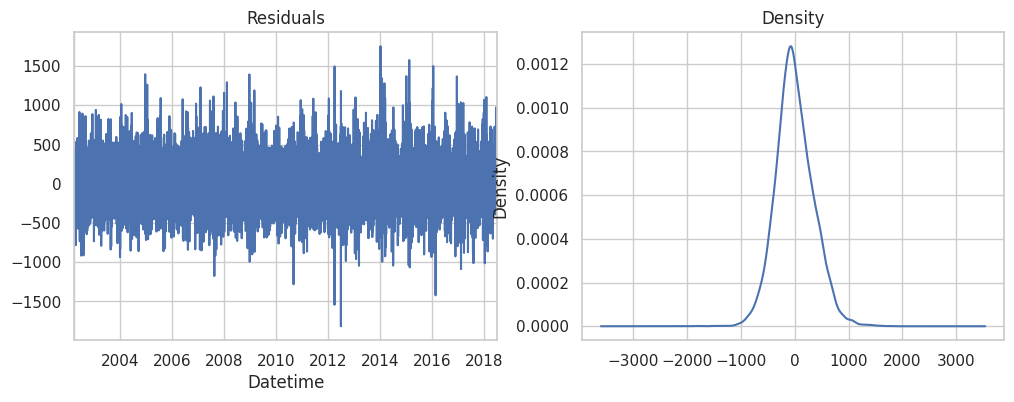

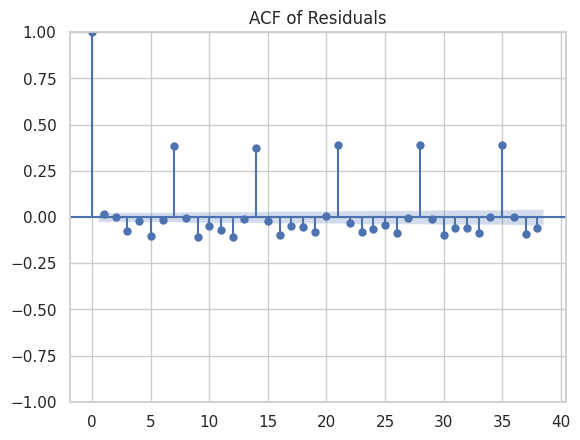

In [ ]:
residuals = fitted_model.resid

plt.figure(figsize=(12, 4))
plt.subplot(121)
residuals.plot(title="Residuals")
plt.subplot(122)
residuals.plot(kind='kde', title='Density')
plt.show()

# ACF of residuals
plot_acf(residuals.dropna())
plt.title("ACF of Residuals")
plt.show()


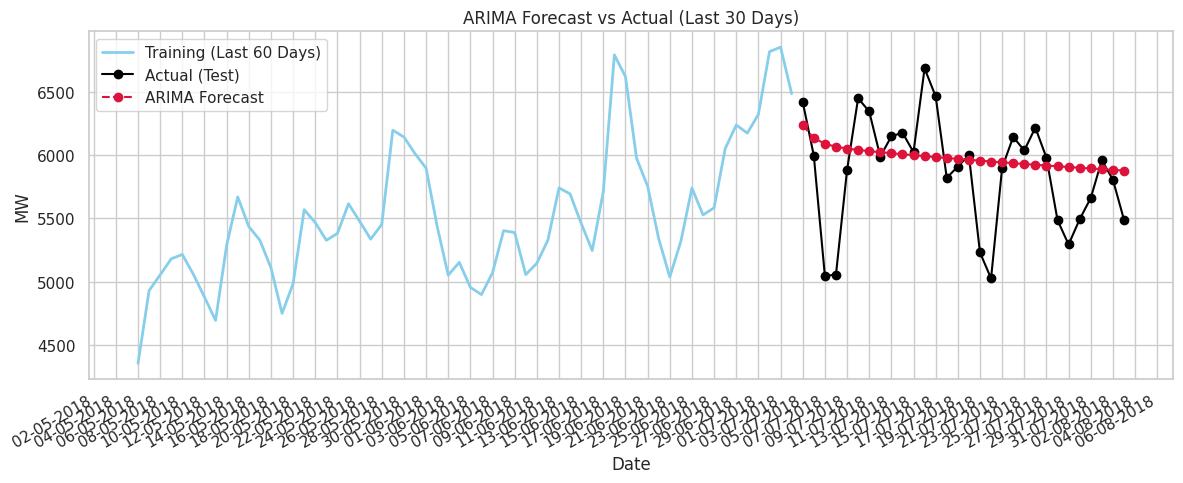

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

forecast = fitted_model.forecast(30)

# Ensure all series have datetime index
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
forecast.index = pd.to_datetime(forecast.index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train[-60:], label="Training (Last 60 Days)", color="skyblue", linewidth=2)
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(forecast, label="ARIMA Forecast", color="crimson", linestyle='--', marker='o')

# Format
plt.title("ARIMA Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.grid(True)
plt.legend()

# Format x-axis for better readability
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import root_mean_squared_error

print("ARIMA MSE Score: ", root_mean_squared_error(forecast, test))

ARIMA MSE Score:  436.127942078134


#SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 3: Fit SARIMA model
# model = SARIMAX(train, order=(2, 2, 0), seasonal_order=(0, 1, 1, 7))
model = SARIMAX(train, order=(2, 0, 2), seasonal_order=(1, 1, 1, 7))
fitted_model = model.fit()

# Step 4: Forecast
forecast = fitted_model.forecast(steps=30)

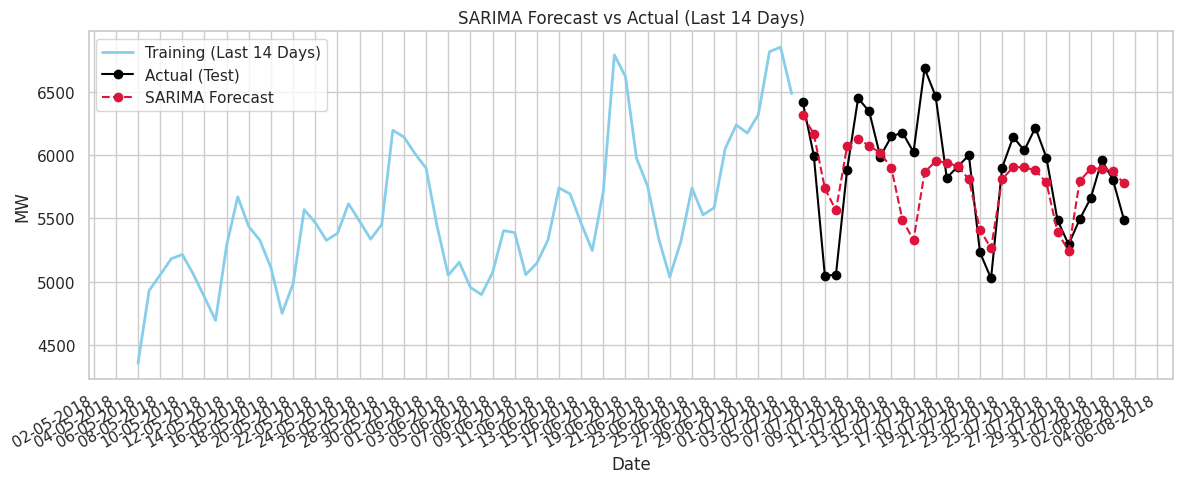

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure all series have datetime index
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
forecast.index = pd.to_datetime(forecast.index)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train[-60:], label="Training (Last 14 Days)", color="skyblue", linewidth=2)
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(forecast, label="SARIMA Forecast", color="crimson", linestyle='--', marker='o')

# Format
plt.title("SARIMA Forecast vs Actual (Last 14 Days)")
plt.xlabel("Date")
plt.ylabel("MW")
plt.grid(True)
plt.legend()

# Format x-axis for better readability
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
# ✅ Remove time from index
# forecast.index = forecast.index.date
# test.index = test.index.date

# Step 5: Evaluate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))

# Step 6: Print results
# print("📅 Forecasted Values (Date only):\n", forecast.round(2))
print(f"\n✅ RMSE: {rmse:.2f}")


✅ RMSE: 344.61


#LSTM Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your data
# series = pd.read_csv("your_file.csv", index_col=0, parse_dates=True)  # Replace with your actual filename
# series = series.squeeze()  # Convert to Series if read as DataFrame

series = train

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30  # 30-day window
X, y = create_sequences(scaled_data, seq_length)

# Reshape input for LSTM: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0645
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0073
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0070
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0062
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0058
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0053
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0048
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0041
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0040
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0039
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0041
Epoch 12/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0041
Epoch 13/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0040
Epoch 14/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0037
Epoch 15/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s

In [ ]:
# Start with the last sequence from training data
forecast_input = scaled_data[-seq_length:].reshape(1, seq_length, 1)
forecast = []

for _ in range(30):
    pred = model.predict(forecast_input)[0]
    forecast.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[pred]], axis=1)

# Inverse scale to original values
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

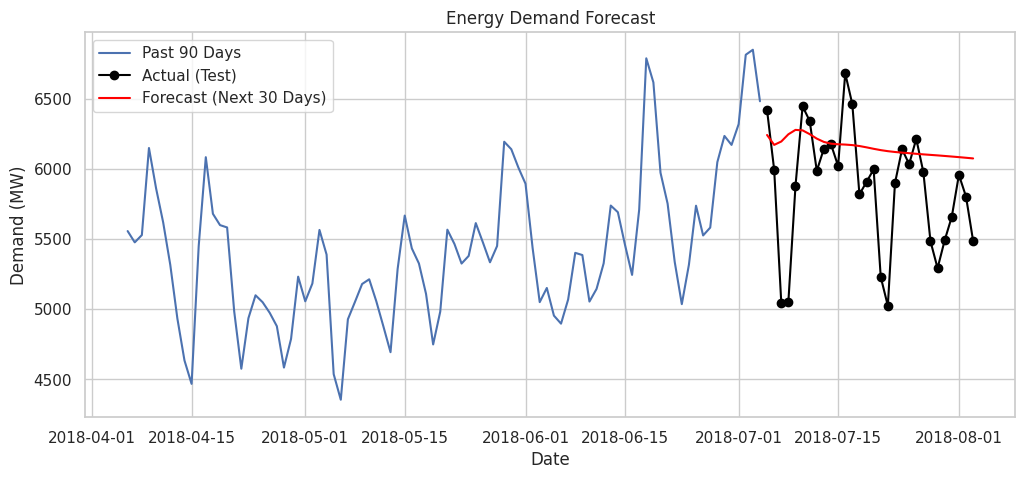

In [ ]:
future_dates = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_series = pd.Series(forecast.flatten(), index=future_dates)

# Plot original + forecast
plt.figure(figsize=(12, 5))
plt.plot(series[-90:], label="Past 90 Days")
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(forecast_series, label="Forecast (Next 30 Days)", color='red')
plt.title("Energy Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("LSTM RMSE: ", root_mean_squared_error(forecast_series, test))

LSTM RMSE:  508.9082884233067


Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 0.1443 - val_loss: 0.0827
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0701 - val_loss: 0.0765
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0691 - val_loss: 0.0796
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0678 - val_loss: 0.0744
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0646 - val_loss: 0.0660
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0558 - val_loss: 0.0513
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0479 - val_loss: 0.0499
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0485 - val_loss: 0.0509
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0466 - val_loss: 0.0501
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0480 - val_loss: 0.0531
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0463 - val_loss: 0.0493
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━

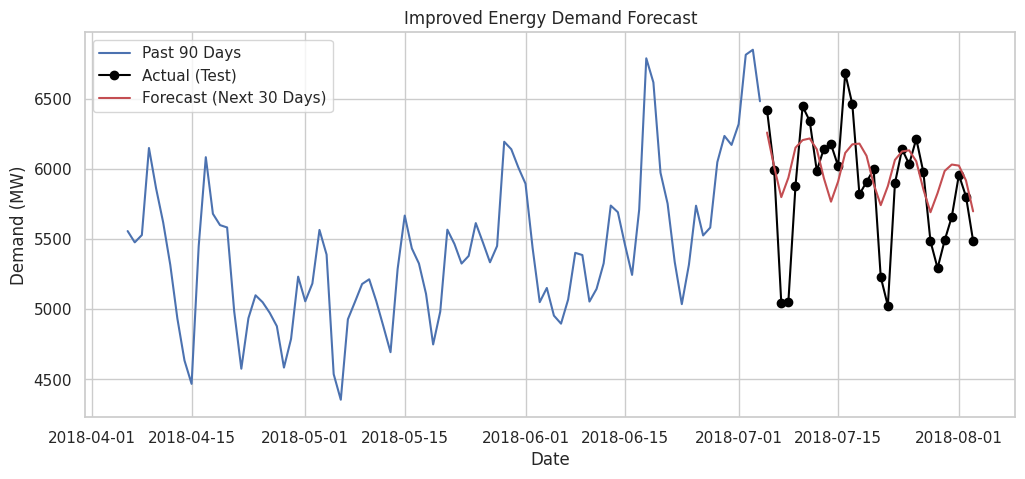

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Normalize
scaler = MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split train/test
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
model.fit(X_train, y_train, epochs=50, batch_size=32,
          validation_data=(X_test, y_test),
          callbacks=[early_stop], verbose=1)

# Forecasting next 30 days
forecast_input = scaled[-seq_length:].reshape(1, seq_length, 1)
forecast = []

for _ in range(30):
    pred = model.predict(forecast_input, verbose=0)[0]
    forecast.append(pred)
    forecast_input = np.append(forecast_input[:, 1:, :], [[pred]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot
past_90_days = series[-90:]
future_dates = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=30)
forecast_series = pd.Series(forecast.flatten(), index=future_dates)

# (Optional) compare with actual if you have future ground truth
# actual_test_series = ...

plt.figure(figsize=(12, 5))
plt.plot(past_90_days, label='Past 90 Days')
# plt.plot(actual_test_series, 'ko-', label='Actual (Test)')  # Uncomment if available
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(forecast_series, 'r-', label='Forecast (Next 30 Days)')
plt.title("Improved Energy Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("LSTM RMSE: ", root_mean_squared_error(forecast_series, test))

LSTM RMSE:  374.2017913903804


DEBUG:cmdstanpy:input tempfile: /tmp/tmpesl9ssfq/ah88e62z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpesl9ssfq/z81epel5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6619', 'data', 'file=/tmp/tmpesl9ssfq/ah88e62z.json', 'init=/tmp/tmpesl9ssfq/z81epel5.json', 'output', 'file=/tmp/tmpesl9ssfq/prophet_modeli3apzlha/prophet_model-20250706112929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:29:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:29:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


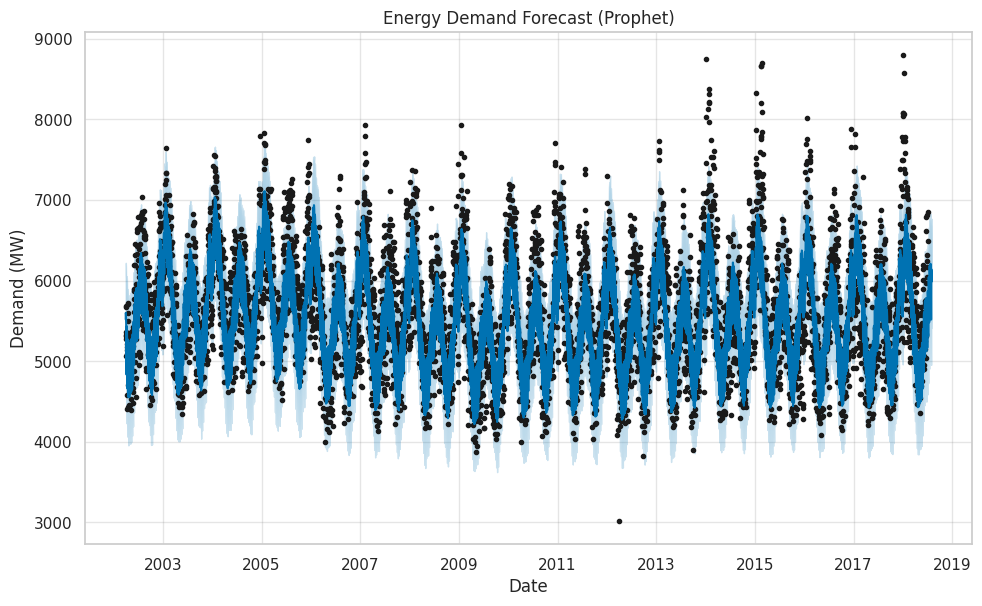

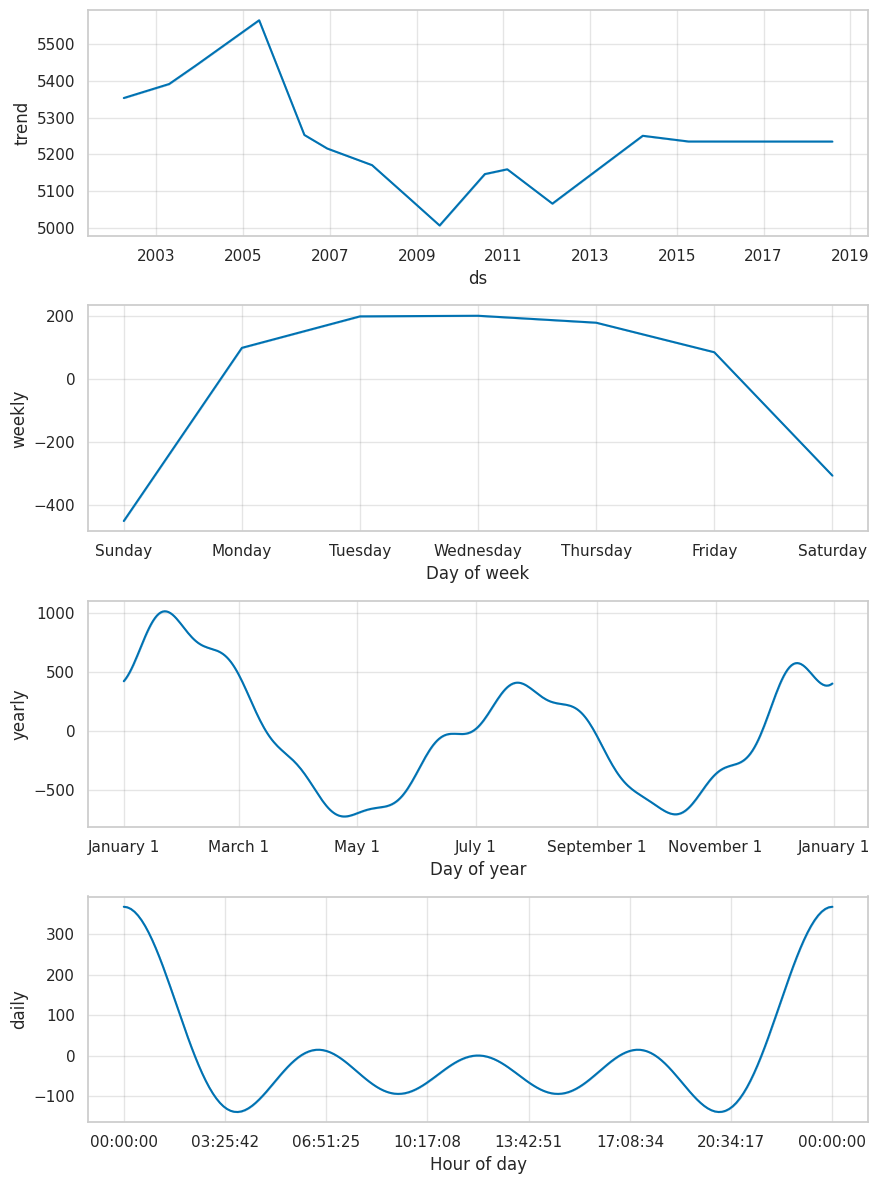

In [ ]:
# Install Prophet (uncomment if running in a new environment)
# !pip install prophet

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Load and prepare data
# series = pd.read_csv("your_file.csv", index_col=0, parse_dates=True)
series = train.squeeze().reset_index()
series.columns = ['ds', 'y']  # Prophet expects 'ds' (date) and 'y' (target)

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(series)

# Create future dataframe and forecast next 30 days
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Energy Demand Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.grid(True)
plt.show()

# Plot seasonality and trend components
fig2 = model.plot_components(forecast)
plt.show()

# Optional: Evaluate if true values are available for comparison
# merged = pd.merge(series, forecast[['ds', 'yhat']], on='ds', how='right')
# merged.dropna(inplace=True)
# rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
# print(f"RMSE: {rmse:.2f}")


In [ ]:
predicted_values = forecast[['ds', 'yhat']].tail(30).set_index('ds')
print(predicted_values)

                   yhat
ds                     
2018-07-05  5868.486587
2018-07-06  5797.305310
2018-07-07  5429.207937
2018-07-08  5309.902312
2018-07-09  5886.392047
2018-07-10  6012.633884
2018-07-11  6040.506866
2018-07-12  6043.844806
2018-07-13  5974.335141
2018-07-14  5605.116970
2018-07-15  5481.879738
2018-07-16  6051.683278
2018-07-17  6168.613166
2018-07-18  6184.745833
2018-07-19  6174.175062
2018-07-20  6088.903106
2018-07-21  5702.429485
2018-07-22  5560.839182
2018-07-23  6111.611251
2018-07-24  6209.262151
2018-07-25  6206.298573
2018-07-26  6177.231760
2018-07-27  6074.456907
2018-07-28  5671.831034
2018-07-29  5515.751368
2018-07-30  6053.955519
2018-07-31  6141.158014
2018-08-01  6129.998129
2018-08-02  6095.051169
2018-08-03  5988.706859


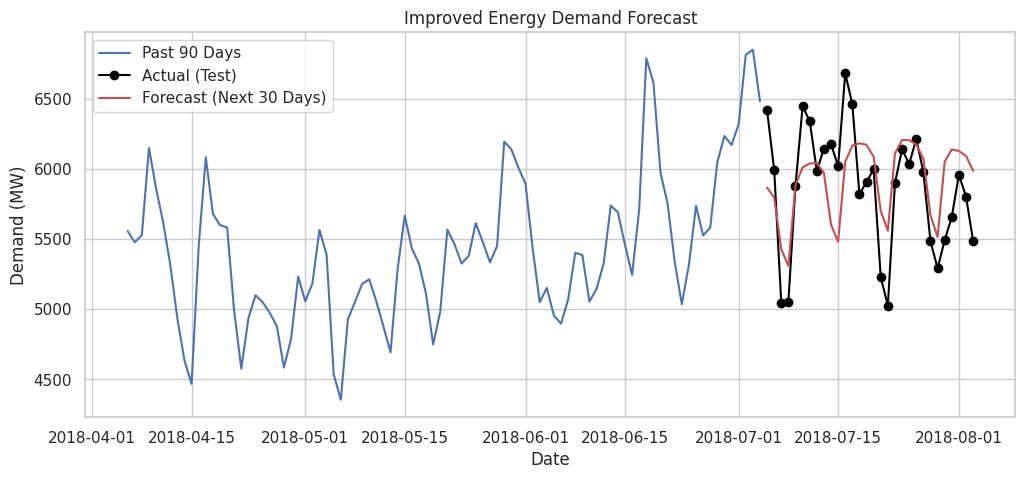

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(past_90_days, label='Past 90 Days')
# plt.plot(actual_test_series, 'ko-', label='Actual (Test)')  # Uncomment if available
plt.plot(test, label="Actual (Test)", color="black", marker='o')
plt.plot(predicted_values, 'r-', label='Forecast (Next 30 Days)')
plt.title("Improved Energy Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Prophet Model: ", root_mean_squared_error(predicted_values, test))

Prophet Model:  354.95259703311746


| Model            | RMSE     |
|------------------|----------|
| ETS              | 571.26   |
| ARIMA            | 436.13   |
| SARIMAX          | 344.61   |
| LSTM (Basic)     | 508.90   |
| LSTM (Best)      | 374.20   |
| Prophet          | 354.95   |


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# build SARIMAX Final model

model = SARIMAX(df, order=(2, 0, 2), seasonal_order=(1, 1, 1, 7))
fitted_model = model.fit()

In [ ]:
import joblib
joblib.dump(fitted_model, "PJM_Model.joblib")

['PJM_Model.joblib']